In [50]:
import os as os
from tqdm import tqdm
import matplotlib.pyplot as plt

import SimpleITK as sitk
import pydicom as pydicom

import numpy as np
import pandas as pd

In [51]:
import re

In [52]:
DATA_DIR = r"/home/thulasiseetha/research/dataset/curated/LungMR/dce"
XL_PATH = r"/home/thulasiseetha/research/dataset/raw/LungMR/Database RM polmone.csv"
PAT_RECORDS_FILE = r"/home/thulasiseetha/research/sithin_projects/lungmr_curation/pat_records.npy"

### Utils

In [53]:
def dcm_tag(attribute):
    
    tag = ""
    
    if attribute=="pid":
        tag = "0010|0020"
    elif attribute=="age":
        tag = "0010|1010"
    elif attribute=="sex":
        tag = "0010|0040"
    elif attribute=="weight":
        tag = "0010|1030"
    elif attribute=="height":
        tag = "0010|1020"
    elif attribute=="contrast_agent":
        tag = "0018|0010"
    elif attribute=="slice_thickness":
        tag = "0018|0050"
    elif attribute=="TR":
        tag = "0018|0080"
    elif attribute=="TE":
        tag = "0018|0081"
    elif attribute=="FA":
        tag = "0018|1314"
    elif attribute=="manufacturer":
        tag = "0008|0070"
    elif attribute=="version":
        tag = "0018|1020"
    elif attribute=="field_strength":
        tag = "0018|0087"
    else:
        print("Not a valid tag")
        
    assert tag!="", "invalid input attribute"
    
    return tag

### Data Statistics

In [54]:
df = pd.read_csv(XL_PATH)[["Patient ID", "pazID", "Espressione PD-L1"]].dropna()
df.head()

,Patient ID,pazID,Espressione PD-L1
0,2578679,paz1,90%
1,2769233,paz2,90%
2,2780061,paz3,<1%
3,2442528,paz4,35%
4,1818594,paz5,<1%


In [55]:
ref_df = df[["Patient ID", "pazID"]]
ref_map = dict(zip(ref_df["Patient ID"].to_list(), ref_df.pazID.to_list()))
inv_ref_map = dict(zip(ref_df["pazID"].to_list(),ref_df["Patient ID"].to_list()))

pid_record_map = np.load(PAT_RECORDS_FILE, allow_pickle=True).item()

In [70]:
stat_df = {
    "pid":[], "ref_id":[], "age":[], "sex":[], "weight":[], "height":[], "contrast_agent":[], "slice_thickness":[], "voxel_spacing":[], "img_matrix":[], "TR":[], "TE":[], 
    "FA":[], "FOV":[], "num_of_phases":[], "acquisition_period":[], "manufacturer":[], "version":[], "field_strength":[], "pdl1>=1%":[], "pdl1>=50%":[]
}

ref_ids = os.listdir(os.path.join(DATA_DIR, "images"))

for ref_id in tqdm(ref_ids, desc="parsing patient/acquisition info"):
    
    if ref_id not in df.pazID.values:
        print(f"ignoring {ref_id} because of missing pd-l1 expression info")
        continue
    
    pid = inv_ref_map[ref_id]

    dce_dict = pid_record_map[pid]["dce"]
    acq_times = sorted(list(dce_dict))

    series_id, _, series_dir = dce_dict[acq_times[0]]
    
    reader = sitk.ImageSeriesReader()
    dcm_files = reader.GetGDCMSeriesFileNames(series_dir, series_id)
    reader.SetFileNames(dcm_files)
    image3D = reader.Execute()
    
    reader = sitk.ImageFileReader()
    reader.SetFileName(dcm_files[0])
    reader.LoadPrivateTagsOn()
    
    reader.ReadImageInformation()
    
    attributes = ["pid", "age", "sex", "weight", "height", "contrast_agent", "slice_thickness", "TR", "TE", "FA", "manufacturer", "version", "field_strength"]
    for attribute in attributes:
        try:
            value = reader.GetMetaData(dcm_tag(attribute))  # Contrast agent name 
        except:
            print(f"{attribute} not found for {anonymous_pid}")
            value = np.nan
            
        stat_df[attribute].append(value)
        

    voxel_spacing = image3D.GetSpacing()  # Voxel Spacing
    img_size = image3D.GetSize()  # Matrix Size
    
    stat_df["ref_id"].append(ref_id)
    stat_df["voxel_spacing"].append(list(np.round(voxel_spacing,2)))
    stat_df["img_matrix"].append(list(img_size))
    stat_df["FOV"].append([np.round(i*j,2) for i,j in zip(img_size, voxel_spacing)])
    stat_df["acquisition_period"].append(np.round((float(max(acq_times))-float(min(acq_times)))/60,2))
    stat_df["num_of_phases"].append(len(acq_times))
    
    pdl1_expression = df[df.pazID==ref_id]["Espressione PD-L1"].item()
    
    offset = 0
    if ">" in pdl1_expression:
        offset += 1
    elif "<" in pdl1_expression:
        offset -= 1
    
    pdl1_value = max([float(i)+offset for i in re.findall(r'\d+', pdl1_expression)])
    
    label1 = 1 if pdl1_value>=1 else 0 #case1
    label2 = 1 if pdl1_value>=50 else 0 #case2
    
    stat_df["pdl1>=1%"].append(label1)
    stat_df["pdl1>=50%"].append(label2)


    
stat_df = pd.DataFrame.from_dict(stat_df)
stat_df.head()
    
stat_df.to_csv("stat_df.csv", index=False)

parsing patient/acquisition info:  44%|████████████▋                | 17/39 [00:12<00:16,  1.31it/s]

contrast_agent not found for paz40


parsing patient/acquisition info:  51%|██████████████▊              | 20/39 [00:14<00:13,  1.37it/s]

ignoring paz23 because of missing pd-l1 expression info


parsing patient/acquisition info: 100%|█████████████████████████████| 39/39 [00:28<00:00,  1.37it/s]


In [79]:
print("# of patients =", len(stat_df.ref_id))

# of patients = 38


In [80]:
stat_df["pdl1>=1%"].value_counts().sort_index()

0    13
1    25
Name: pdl1>=1%, dtype: int64

In [81]:
stat_df["pdl1>=50%"].value_counts().sort_index()

0    25
1    13
Name: pdl1>=50%, dtype: int64

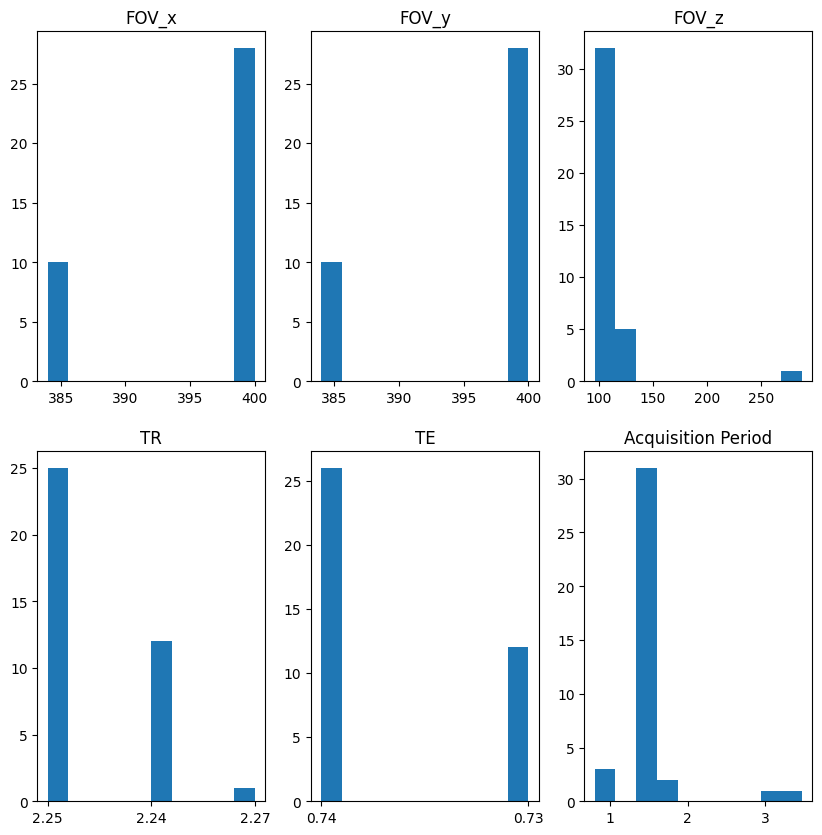

In [82]:
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

axs[0,0].hist(np.array(stat_df.FOV.to_list())[:,0])
axs[0,0].set_title("FOV_x")
axs[0,1].hist(np.array(stat_df.FOV.to_list())[:,1])
axs[0,1].set_title("FOV_y")
axs[0,2].hist(np.array(stat_df.FOV.to_list())[:,2])
axs[0,2].set_title("FOV_z")
axs[1, 0].hist(stat_df.TR)
axs[1, 0].set_title("TR")
axs[1, 1].hist(stat_df.TE)
axs[1,1].set_title("TE")
axs[1,2].hist(stat_df.acquisition_period)
axs[1,2].set_title("Acquisition Period")
plt.show()